## Importing Libraries

In [1]:
import os
import csv
import wget
import json
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Defining Hyper-Parameters

In [2]:
embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
# Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 (train size)
# to see the best effects
training_size=160000
test_portion=.1

## Downloading Larger Data (Transfer Learning)

In [3]:
# This is a cleaned Stanford dataset with removed LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# The above changed data is hosted on the below url to make it easier to use in this notebook
path = os.getcwd()+"\..\data\\training_cleaned.csv"
url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv"
train = wget.download(url, out = path)

100% [......................................................................] 238942690 / 238942690

In [6]:
corpus = []

num_sentences = 0

# Creating a list items where the first item is the text, found in row[5], and the second is the label. 
# Note that the label is a '0' or a '4' in the text. When it's the former, make
# your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences

with open("../data/training_cleaned.csv", encoding="utf8") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        list_item.append(row[5])
        this_label=row[0]
        if this_label=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)

In [7]:
corpus

[["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
  0],
 ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
  0],
 ['@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
  0],
 ['my whole body feels itchy and like its on fire ', 0],
 ["@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. ",
  0],
 ['@Kwesidei not the whole crew ', 0],
 ['Need a hug ', 0],
 ["@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?",
  0],
 ["@Tatiana_K nope they didn't have it ", 0],
 ['@twittera que me muera ? ', 0],
 ["spring break in plain city... it's snowing ", 0],
 ['I just re-pierced my ears ', 0],
 ["@caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . .",
  0],
 ['@octolinz16 It it c

In [8]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


## Defining Target, Tokenizing and Padding

In [9]:
# Defining target
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

# Tokenizing and Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Splitting data in test and train set
split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [10]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

138011
1


## Downloading Experiment Data

In [11]:
# Note this is the 100 dimension version of GloVe from Stanford
# It is unzipped and hosted on the below url to make this notebook easier
path = os.getcwd()+"\..\data\\glove.6B.100d.txt"
url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt"
experiment = wget.download(url, out = path)

100% [......................................................................] 347116733 / 347116733

In [15]:
embeddings_index = {}
with open('../data/glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [16]:
print(len(embeddings_matrix))
# Expected Output
# 138859

138012


## Building a Model

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        vocab_size+1, 
        embedding_dim,
        input_length=max_length,
        weights=[embeddings_matrix], 
        trainable=False
    ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

test_sequences = np.array(test_sequences)
test_labels = np.array(test_labels)
training_sequences = np.array(training_sequences)
training_labels = np.array(training_labels)

num_epochs = 50
history = model.fit(
    training_sequences, 
    training_labels,
    epochs=num_epochs,
    validation_data=(test_sequences, test_labels), 
    verbose=2
)

print("Training Complete")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 100)           13801200  
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 13,866,353
Trainable params: 65,153
Non-trainable params: 13,801,200
_____________________________________

## Visualising Accuracy and Loss

<Figure size 432x288 with 0 Axes>

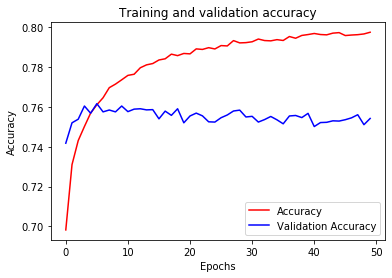

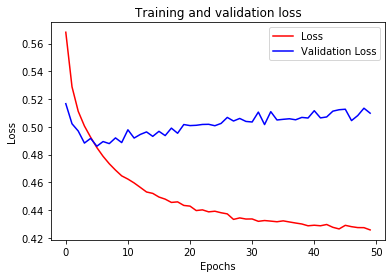

<Figure size 432x288 with 0 Axes>

In [19]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

# Expected Output
# A chart where the validation loss does not increase sharply!